# I. Introduction to Machine Learning for Time Series

## Contents

- What is a time series?
- Why is times series different?
- Machine learning tasks on time series
- Reduction

## I.1. What is a time series?

### I.1.A. Conceptual definition

Imagine you're tracking something over time, like the temperature outside your window every hour, or the number of visitors to a website each day. A **time series** is simply a sequence of measurements taken at regular intervals. The key thing is that the order of the measurements matters, because the value at one point in time is often related to the values that came before it. It's like a story unfolding over time, and we want to understand that story and maybe even predict what happens next.

### I.1.B. Mathematical definition

A **time series** can be defined as a sequence of data points, typically real-valued, indexed by time. Let $T$ be the index set representing the time points at which the measurements are taken. For a discrete time series, $T$ is a discrete subset of the real numbers (often the integers or a subset of them, e.g., $T = \{1, 2, 3, \dots\}$ or $T = \{t_1, t_2, \dots, t_n\}$ where $t_i$ are equally spaced). The time series itself is then denoted as $\{x_t\}_{t \in T}$, where $x_t$ is the observed value at time $t$.

More formally, a time series can be considered a realization of a stochastic process $\{X_t\}_{t \in T}$, where for each $t \in T$, $X_t$ is a random variable. The observed sequence $\{x_t\}_{t \in T}$ is one particular outcome of this underlying probabilistic mechanism evolving over time. The analysis of a time series often involves making statistical inferences about the properties of this stochastic process based on the observed data.

### I.1.C. Single and multiple time series

In [1]:
from utils import ExampleDataLoader, plot_series_slice, plot_series

#### Univariate time series

A univariate time series focuses on a single variable measured over time. The goal is to analyze the patterns and predict future values of that one specific series based solely on its historical behavior.

##### Chemical process experiment temperature 

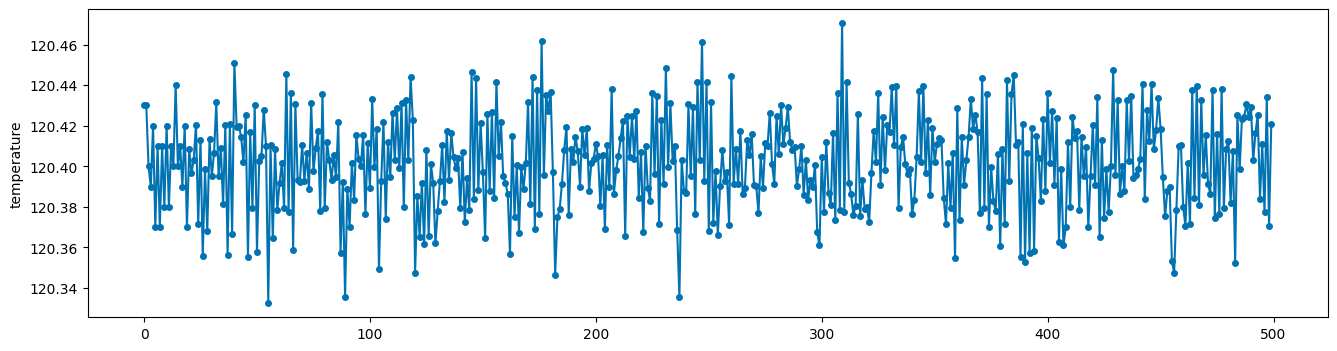

In [2]:
experiment = 2

temperature = ExampleDataLoader("process").load(name="temperature", idx=experiment)
_ = plot_series(temperature)

##### Chemical process experiment pressure

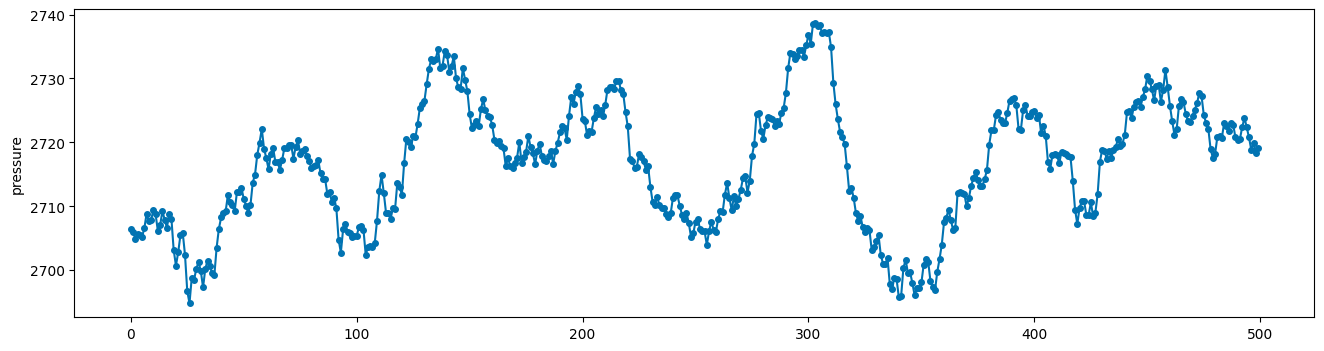

In [3]:
pressure = ExampleDataLoader("process").load(name="pressure", idx=experiment)
_ = plot_series(pressure)

##### Day-ahead spanish electricity demand

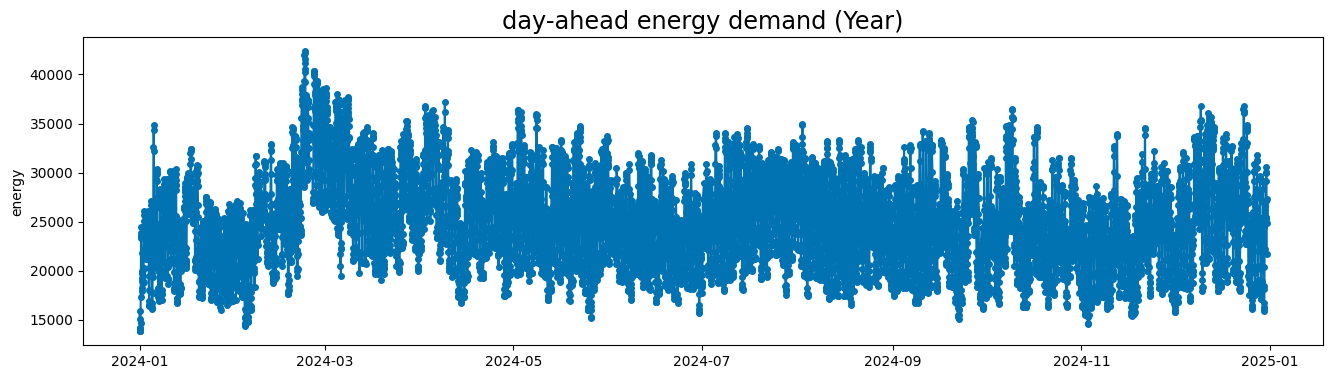

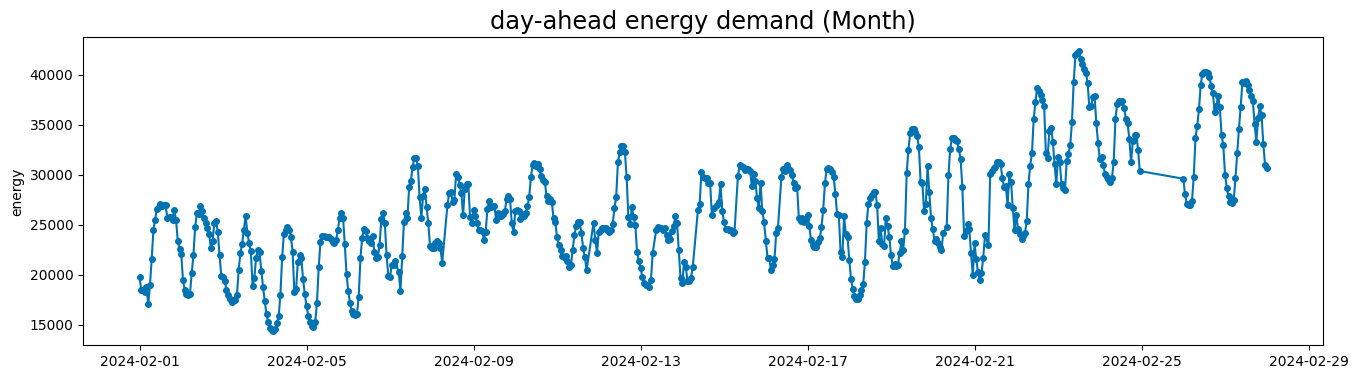

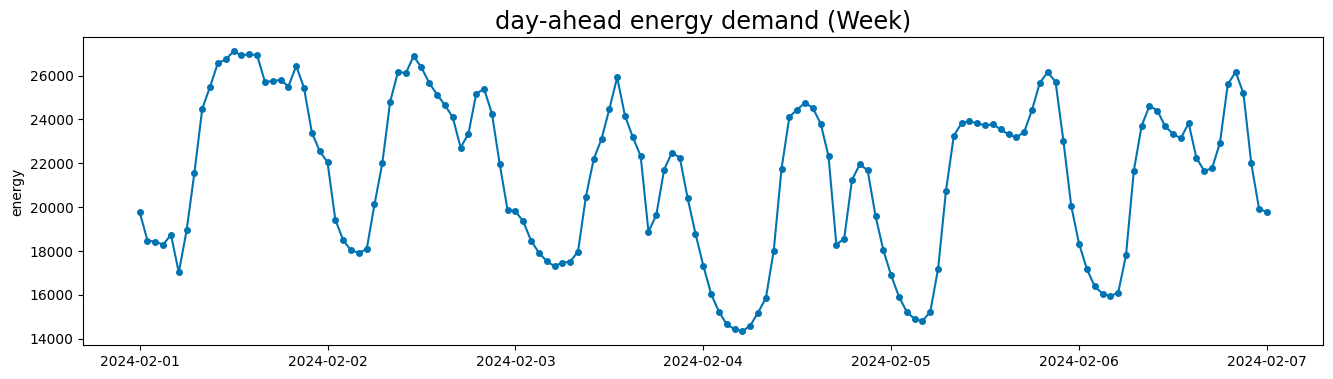

In [4]:
energy = ExampleDataLoader("energy").load().set_index("datetime")

energy_yr = plot_series_slice(
    energy, 
    start="2024-01-01 00:00:00", 
    stop="2024-12-31 00:00:00",
    freq="h",    
    title="day-ahead energy demand (Year)",
    return_data=True,
)

energy_month = plot_series_slice(
    energy, 
    start="2024-02-01 00:00:00", 
    stop="2024-02-28 00:00:00",
    freq="h",
    title="day-ahead energy demand (Month)",
    return_data=True,
)

energy_week = plot_series_slice(
    energy, 
    start="2024-02-01 00:00:00", 
    stop="2024-02-7 00:00:00",
    freq="h",
    title="day-ahead energy demand (Week)",
    return_data=True,
)

###### Some unique characteristics of Time Series

**1. Temporal Dependence (Autocorrelation):**
   - Observing the data, especially the weekly and monthly views, suggests a clear dependency between consecutive data points. For instance, a high energy demand at a particular hour is likely to be followed by a demand that is not drastically different in the next hour. The repeating patterns within the week and month further indicate autocorrelation, where demand at similar times on different days or weeks is correlated. Machine learning models will need to capture this persistence and cyclical dependency to accurately predict future demand.

**2. Order Matters:**
   - The chronological order of the energy demand data is fundamental. If we were to shuffle the data points, the inherent patterns related to time (daily peaks and troughs, weekly cycles, seasonal variations across the year) would be lost. Training an ML model on shuffled data would yield meaningless predictions as it would not learn the temporal relationships. When preparing this data for ML, we must maintain its sequential order and split it into training and testing sets based on time.

**3. Non-Stationarity:**
   - The yearly plot shows fluctuations in the overall level of energy demand across the year. There appear to be periods of higher demand (e.g., around March 2024 and potentially towards the end of the year) and lower demand. This suggests the presence of non-stationarity in the mean. While a clear long-term trend might not be immediately obvious from this single year of data, longer timeframes could reveal one. Additionally, the variance of the demand might also change over time, indicating non-stationarity in the variance. Preprocessing techniques might be needed to address these non-stationarities before applying certain ML models.

**4. Seasonality and Cyclic Patterns:**
   - The monthly plot clearly exhibits a weekly seasonality, with peaks and troughs repeating roughly every 7 days. This is likely due to the difference in energy consumption patterns between weekdays (typically higher demand due to industrial and commercial activity) and weekends (lower demand). The weekly plot further emphasizes this strong weekly cycle, showing a consistent pattern within each week. The yearly plot hints at potential longer-term seasonal patterns across the year (e.g., higher demand in certain months due to heating or cooling needs), although one year of data provides limited insight into inter-annual seasonality.

**5. Trend:**
   - From the single year of data presented, it's difficult to definitively identify a long-term trend (increasing or decreasing demand over multiple years). However, within the observed year, there might be shorter-term trends or level shifts. A longer time series would be necessary to ascertain the presence and nature of a significant underlying trend.

**6. Irregular Intervals and Missing Data:**
   - The graphs appear to show data points at regular intervals (though the exact granularity isn't specified). If the underlying data collection had any missing values or irregular intervals, this would need to be addressed before applying most ML models. Imputation techniques suitable for time series data would be necessary to handle missing values while preserving the temporal structure.

**7. Feature Engineering from Time:**
   - We could engineer several time-based features:
     - **Lagged values:** Past energy demand at previous time steps (e.g., demand at the previous hour, previous day, same hour last week).
     - **Calendar features:** Day of the week, day of the month, month of the year, hour of the day, whether it's a holiday, etc. These features can help the model learn the recurring patterns associated with specific times.
     - **Rolling statistics:** Moving averages or rolling standard deviations of past demand to capture short-term trends or volatility.

**8. Evaluation Metrics:**
   - When evaluating ML models for forecasting this energy demand, standard regression metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) would be appropriate to measure the magnitude of the prediction errors. Additionally, metrics like Mean Absolute Percentage Error (MAPE) could provide a relative measure of the forecast accuracy. Given the temporal nature, it's crucial to evaluate the model's performance on a held-out test set that comes *after* the training data.

**9. Forecasting Horizon:**
   - The choice of ML model and the feature engineering might be influenced by the specific forecast horizon (in this case 24 hours). Some models might be better suited for shorter-term forecasts, while others can handle longer horizons more effectively.

**10. Domain Knowledge:**
   - Understanding the factors that influence energy demand (e.g., weather conditions, economic activity, social events, electricity pricing) can be highly beneficial. Incorporating weather forecasts or calendar information about holidays could significantly improve the accuracy of ML models predicting day-ahead energy demand.

#### Multiple time series

##### Multivariate time series
In contrast, a multivariate time series involves two or more variables that are measured over the same time period. The analysis here considers not only the temporal dependencies within each individual series but also the interdependencies and correlations between these multiple variables to understand their joint evolution and make predictions.

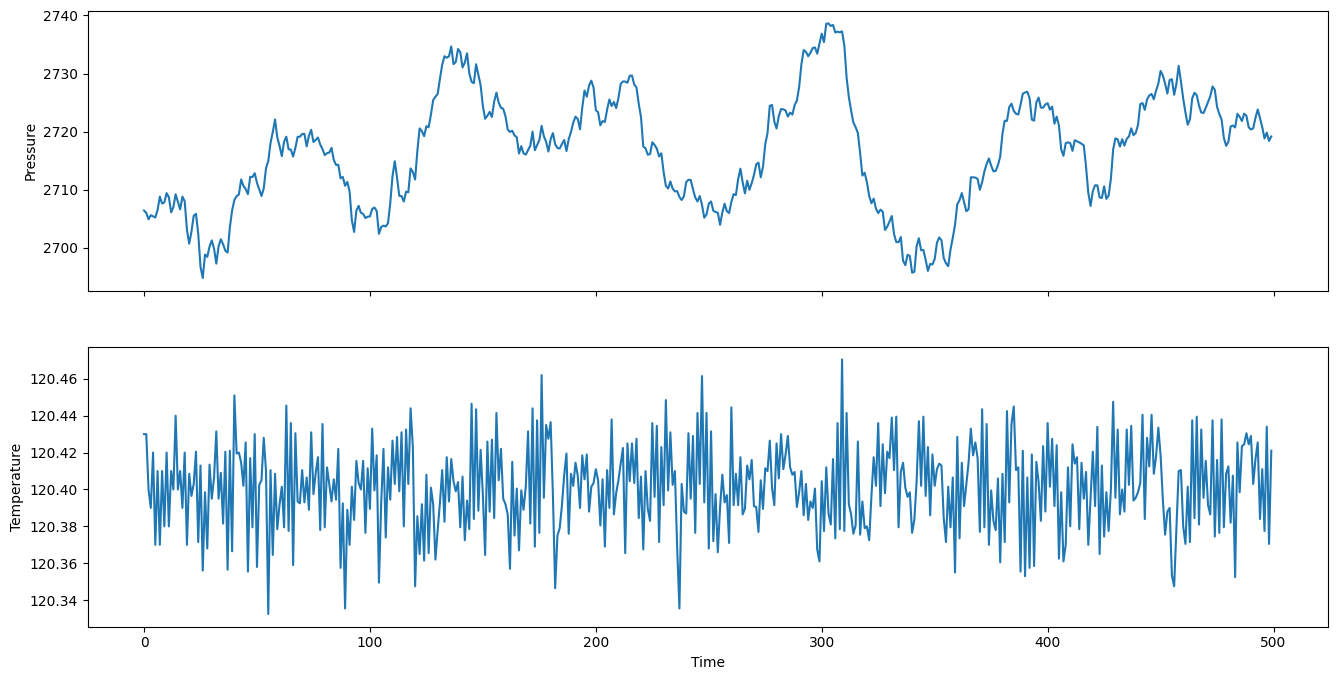

In [5]:
from matplotlib import pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(16, 8), sharex=True)
pressure.plot(ax=ax0)
temperature.plot(ax=ax1)
ax0.set(ylabel="Pressure")
ax1.set(ylabel="Temperature", xlabel="Time");

##### Panel data
Panel data, also known as longitudinal data, involves observations of multiple entities (like individuals, companies, or countries) over several time periods. This type of data has both a cross-sectional dimension (the different entities) and a time series dimension (the measurements over time for each entity). Analyzing panel data allows us to study both the differences between these entities and the changes within them over time, providing a richer understanding compared to analyzing separate time series or cross-sectional data alone.

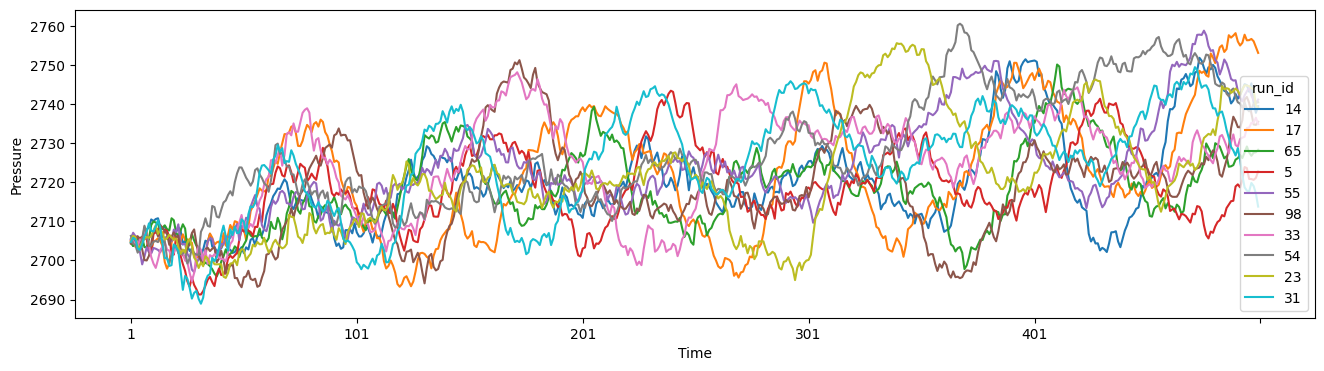

In [6]:
experiments = ExampleDataLoader("process").load()

fig, ax = plt.subplots(1, figsize=(16, 4))
experiments["pressure"].sample(10).T.plot(ax=ax)
ax.set(ylabel="Pressure", xlabel="Time");

In [7]:
experiments["pressure"]

time,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
run_id,,,,,,,,,,,,,,,,,,,,,
1,2704.3,2705.0,2706.2,2707.2,2705.1,2703.8,2704.0,2704.9,2703.2,2705.3,...,2728.680,2727.720,2726.915,2724.810,2728.455,2730.335,2727.980,2724.810,2726.755,2728.005
2,2706.4,2706.0,2704.9,2705.6,2705.4,2705.2,2706.5,2708.8,2707.6,2707.8,...,2720.365,2720.555,2722.385,2723.810,2722.330,2720.750,2718.820,2719.830,2718.390,2719.165
3,2705.5,2704.5,2707.0,2706.7,2704.8,2701.9,2703.7,2704.6,2706.7,2706.8,...,2729.260,2732.810,2732.280,2730.475,2729.335,2729.260,2728.720,2727.765,2729.900,2731.535
4,2705.3,2704.8,2704.4,2703.6,2705.1,2708.5,2705.6,2703.9,2698.8,2698.5,...,2727.655,2728.765,2728.740,2730.325,2731.310,2731.560,2731.430,2732.260,2734.145,2735.170
5,2704.8,2704.4,2706.1,2706.1,2705.4,2706.1,2705.7,2705.5,2702.2,2702.0,...,2719.480,2718.715,2720.720,2723.900,2723.635,2720.875,2720.835,2720.630,2721.130,2722.815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2703.8,2705.5,2705.4,2703.3,2705.1,2707.3,2706.4,2705.1,2703.3,2702.8,...,2743.935,2745.170,2748.605,2746.980,2744.675,2745.310,2745.320,2747.290,2750.310,2751.865
96,2703.8,2705.2,2706.5,2703.7,2701.9,2703.4,2704.6,2707.0,2709.6,2710.6,...,2735.970,2736.865,2737.510,2736.895,2737.695,2736.815,2736.545,2737.180,2735.885,2737.750
97,2705.0,2705.1,2705.4,2705.4,2705.3,2705.3,2704.5,2706.5,2706.6,2706.1,...,2742.945,2742.510,2739.720,2737.440,2739.335,2743.045,2743.195,2743.120,2742.430,2741.055


##  I.2. Why is time series different?

#### Temporal dependence (Autocorrelation)

Past values influence future values, requiring models like RNNs or ARIMA to capture these dependencies.

#### Order matters


Sequence is critical; shuffling is invalid. Data splitting must be chronological to simulate forecasting.

#### Non-stationarity

Statistical properties change over time (trends, seasonality); preprocessing (differencing, transformations) may be needed.

#### Seasonality and cyclic patterns

Repeating short-term (seasonality) and longer-term (cycles) fluctuations that ML models should learn, often via feature engineering or specialized architectures.

#### Trend


Long-term direction needing identification and modeling, either explicitly or implicitly by ML models.

#### Irregular intervals and missing data

Real-world data might have gaps or uneven spacing, requiring imputation techniques respecting temporal order or models that handle irregularity.

#### Feature engineering from time

Time indices can generate valuable features (lags, rolling stats, calendar features) to improve model performance.

#### Evaluation metrics

Standard ML metrics might be insufficient; time series-aware metrics (MAE, RMSE, MAPE, Theil's U) are preferred.

#### Forecasting horizon

Prediction timeframe (short, medium, long-term) impacts model choice and performance.

#### Domain knowledge

External understanding of the data-generating process is crucial for feature engineering, model selection, and interpretation.

## I.3. Machine Learning tasks on time series

- Time series data gives rise to a variety of distinct learning tasks.
- While these tasks can be related, it is crucial to understand their differences to apply appropriate machine learning techniques.

_For a deep overview of the primary time series learning tasks have a look at this [paper](http://learningsys.org/neurips19/assets/papers/sktime_ml_systems_neurips2019.pdf)_.

### I.3.A. Time series Regression/Classification

We observe $N$ independent and identically distributed (i.i.d.) panel data training instances of feature-label pairs $(x_i, y_i)$, where $i = 1, ..., N$. Each instance's feature is a time series $x_i = (x_i(t_1), ..., x_i(t_T))$.

The task is to learn a predictor $\hat{f}$ that can accurately predict a new target value $\hat{y}$ for a new input time series $x_*$:

   $$\hat{y} = \hat{f}(x_*)$$

   -   For regression, the target variable $y_i$ is a continuous value, $y_i \in \mathbb{R}$. 
   -   For classification, the target variable $y_i$ takes a value from a finite set of class values.
   -   Time-invariant features may also be present.
   -   The main difference from standard tabular supervised learning is that some features are time series rather than simple primitives (e.g., numbers or strings).
   -   Important sub-cases include:
        -   Equally spaced observation times.
        -   Equal length time series

**Example (Regression):**

Predicting the electricity consumption of a household based on past hourly consumption patterns. Here, the time series $x_i$ represents the hourly consumption, and $y_i$ is the total daily consumption (a continuous value).

**Example (Classification):**

Identifying whether a patient has a specific heart condition based on their ECG time series data. Here, the time series $x_i$ is the ECG signal, and $y_i$ is a class label (e.g., "Condition Present" or "Condition Absent").

### I.3.B. Classical forecasting

Given past observations $y = (y(t_1), ..., y(t_T))$ of a single time series, the task is to learn a forecaster $\hat{f}$ that can make accurate temporal forward predictions $\hat{y}$ of observations at given time points $h_1, ..., h_H$ of the forecasting horizon, where $\hat{y} = (\hat{y}(h_1), ..., \hat{y}(h_H))$ denotes the forecasted series.

No i.i.d. assumption is made in classical forecasting. Variants of forecasting can be distinguished by:

   -   Whether additional related time series are observed (multivariate data).
   -   For multivariate data, whether one forecasts a single series or multiple series jointly (exogeneity vs. vector forecasting).
   -   Whether the forecasting horizon lies:
        -   In the observed time horizon (in-sample predictions).
        -   In the future of the observed time series (forecasting).
        -   For multivariate data, only in the future of the target variable but not the exogenous variables (nowcasting).
   -   Whether there is a single time point to forecast ($H = 1$) or not (single-step vs. multi-step).
   -   Whether the forecasting horizon is known during training or only during forecasting (functional vs. discrete forecast).

**Example (Forecasting):**

Predicting the price of oil based on its past prices (univariate) versus predicting the price of oil based on its past prices, global economic indicators, and political events (multivariate).

**Example (Multi-step Forecasting):**

Predicting the next day's temperature (single-step) versus predicting the temperature for the next week (multi-step).

### I.3.C. Supervised/Panel forecasting

We observe $N$ i.i.d. panel data training instances $(y_i)$, where $i = 1, ..., N$. Each instance is a sequence of past observations $y_i = (y_i(t_1), ..., y_i(t_T))$. The task is to use the training data to learn a supervised forecaster $\hat{f}$ that can make accurate temporal forward predictions $\hat{y}_i$ for a new instance $y_*$ at given time points $h_1, ..., h_H$ of the forecasting horizon, where $\hat{y}_i = (\hat{y}_i(h_1), ..., \hat{y}_i(h_H))$ is the forecasted series:

   $$\hat{y}_i = \hat{f}(y_*, h_j)$$

   The training instances do not necessarily lie in the past of $y$ and may involve observations at past and future time points. Variants include panel data with additional time-constant features and the same variants as found in classical forecasting.


**Example:**

Predicting the energy consumption of individual buildings in a city, where each building has its own time series of past consumption. Here, we have panel data (multiple buildings), and we want to forecast each building's future consumption. We might also have time-constant features for each building, such as its size, insulation level, and occupancy.


### I.3.D. Time series annotation

For given observations $x = (x(t_1), ..., x(t_T))$ of a single time series, the task is to learn an annotator that accurately predicts a series of annotations $\hat{y} = (\hat{y}(a_1), ..., \hat{y}(a_A))$ for the observed series $x$, where $a_1, ..., a_A$ denote the time indices of the annotations.

   The task varies by the value domain and interpretation of the annotations $\hat{y}$ in relation to $x$:

   -   In change-point detection, $\hat{y}$ contains change points and the type of change point.
   -   In anomaly detection, the $a_j$ are a subset of the $t_j$ and indicate anomalies, possibly with the anomaly type.
   -   In segmentation, the $a_j$ are interpreted to subdivide the series $x$ into segments, annotated by the type of segment.

   Time series annotation can also be found in supervised form, with partial annotations within a single time series, or multiple annotated i.i.d. panel data training instances, as well as in entirely unsupervised form.

**Example (change-point detection):**

Identifying when significant changes occur in a machine's vibration patterns, indicating potential malfunctions.

**Example (anomaly detection):**

Detecting fraudulent transactions in a time series of credit card activity.

**Example (segmentation):**

Dividing a time series of human activity data (e.g., from a wearable sensor) into segments corresponding to different activities like walking, running, and sitting.


### I.4. Reduction

![](../img/reduction-map.png)

Reduction is a technique that decomposes a complex task into simpler, related tasks. This allows algorithms developed for simpler tasks to be adapted and used to solve more complex ones.

In time series analysis, reduction plays a crucial role in enabling the use of standard machine learning algorithms (like those in scikit-learn) for time series problems.

**Example: Forecasting as Regression**

   -   A common reduction is to transform a forecasting problem into a regression problem.

   -   This is often done using a "sliding window" approach:

        -   The time series is divided into overlapping windows.

        -   Each window's past values become the features for a regression model.

        -   The value(s) to be predicted within or immediately following the window become the target variable(s).

   -   By doing this, we can use any regression algorithm to predict future time series values.

   -   Reduction helps to unify different time series tasks and provides a framework for developing more versatile and efficient solutions.

![](../img/forecasting-to-regression-reduction.png)